In [1]:
import torch

In [2]:
import torch.nn as nn

In [3]:
from torch.utils.data import Dataset

In [58]:
class BayesianNN(nn.Module):
    def __init__(self, input_size, hidden_size, alpha=0.5):
        super(BayesianNN, self).__init__()
        self.hidden_size = hidden_size
        self.alpha = alpha
        
        self.W_mean = nn.Linear(input_size, hidden_size)
        self.Score = nn.Linear(hidden_size, 1)
        self.W_var = nn.Linear(input_size, hidden_size)
        self.Var = nn.Linear(hidden_size, 1)
        self.Loss = nn.MSELoss(reduction='none')
    
    def forward(self, inputs, targets):
        hidden = self.W_mean(inputs)
        scores = self.Score(nn.ReLU()(hidden))
        var = self.W_var(inputs)
        var = self.Var(nn.ReLU()(var))
        Loss = (1-self.alpha)*self.Loss(scores, targets)/(var**2)+self.alpha*torch.log(var**2)
        return scores, Loss

In [105]:
data = pd.read_excel('Sales_SE.xls')

In [106]:
data.head()

,"(page, index)",latitude,longitude,address,Apt #,#beds,#baths,#square_feet,price
0,"(50, 0)",40.770901,-73.958702,207 East 74,12J,1.0,1.0,NaN,925000
1,"(50, 1)",40.780899,-73.951599,204 East 90th Street,4E,2.0,1.0,750.0,535000
2,"(50, 2)",40.737701,-73.981903,235 E 22nd Street,12Q,NaN,1.0,NaN,515000
3,"(50, 3)",40.761501,-73.991402,415 West 46th Street,4B,1.0,1.0,NaN,585000
4,"(50, 4)",40.778925,-73.948275,360 East 89th Street,23A,3.0,3.5,NaN,4235000


In [107]:
data = data.drop(['(page, index)', 'address', 'Apt #'], axis=1)

In [108]:
data['#beds_mv'] = data['#beds'].isnull().astype(int)
data['#baths_mv'] = data['#baths'].isnull().astype(int)
data['#square_feet_mv'] = data['#square_feet'].isnull().astype(int)
bed_mean = round(np.mean(data['#beds'][data['#beds_mv']==0]))
bath_mean = round(np.mean(data['#baths'][data['#baths_mv']==0]))
sf_mean = np.mean(data['#square_feet'][data['#square_feet_mv']==0])
bed_mean, bath_mean, sf_mean

(2, 2, 1292.8979768786128)

In [109]:
data['#beds'] = data['#beds'].fillna(bed_mean)
data['#baths'] = data['#baths'].fillna(bath_mean)
data['#square_feet'] = data['#square_feet'].fillna(sf_mean)

In [110]:
data.head()

,latitude,longitude,#beds,#baths,#square_feet,price,#beds_mv,#baths_mv,#square_feet_mv
0,40.770901,-73.958702,1.0,1.0,1292.897977,925000,0,0,1
1,40.780899,-73.951599,2.0,1.0,750.000000,535000,0,0,0
2,40.737701,-73.981903,2.0,1.0,1292.897977,515000,1,0,1
3,40.761501,-73.991402,1.0,1.0,1292.897977,585000,0,0,1
4,40.778925,-73.948275,3.0,3.5,1292.897977,4235000,0,0,1


In [120]:
np.random.seed(1352)
n_train = int(0.85*len(data))
n_test = int(0.15*len(data))
shuffled_data = data.loc[np.random.permutation(data.index), :]
X_train, y_train = shuffled_data.iloc[:n_train, :].drop(['price'], axis=1), shuffled_data.iloc[:n_train]['price']
X_test, y_test = shuffled_data.iloc[n_train:, :].drop(['price'], axis=1), shuffled_data.iloc[n_train:]['price']

In [121]:
X_train = torch.from_numpy(np.array(X_train)).float()
y_train = torch.from_numpy(np.array(y_train)).float().view(-1, 1)
X_test = torch.from_numpy(np.array(X_test)).float()
y_test = torch.from_numpy(np.array(y_test)).float().view(-1, 1)

In [94]:
import torch.optim as optim

In [135]:
optimizer = optim.Adam(bnn.parameters(), lr=1e-3)
for i in range(100):
    print(i)
    for it, batch in enumerate(zip(X_train, y_train)):
        #te = time.time()-begin
        #print('Time elapsed after adding nodes: {:.0f}h {:.0f}m {:.0f}s'.format(te//60//60, te//60%60, te%60))
        bnn.zero_grad()
        price, loss = bnn(*batch)
        #te = time.time()-begin
        #print('Time elapsed after running model: {:.0f}h {:.0f}m {:.0f}s'.format(te//60//60, te//60%60, te%60))
        loss.backward()
        optimizer.step()
        #te = time.time()-begin
        #print('Time elapsed after updating parameters: {:.0f}h {:.0f}m {:.0f}s'.format(te//60//60, te//60%60, te%60))
        if it%1000 == 0:
            print('loss:{}'.format(loss.item()))
            y_test_lr, y_loss = bnn(X_test, y_test)
            print(r2_score(y_test, y_test_lr.detach().numpy()))

0
loss:10489.8681640625
0.3098318298231173
loss:15.677440643310547
0.3235767924491407
loss:13.217111587524414
0.3318668893226554
loss:23.332962036132812
0.336307166296376
loss:26.236095428466797
0.33994132782689734
loss:116.85672760009766
0.34184151739490876
loss:32.4718017578125
0.33939317083540976
loss:21.221296310424805
0.33799219872904396
loss:16.832599639892578
0.3456252495206049
loss:30.114240646362305
0.347715013964204
loss:148.66131591796875
0.3465898644110058
1
loss:350.07476806640625
0.34711699976986377
loss:12.191910743713379
0.3492156182756099
loss:12.355659484863281
0.351151515534705
loss:13.224266052246094
0.351284223486951
loss:13.730917930603027
0.3517873103952974
loss:22.1088809967041
0.351195418544863
loss:14.058555603027344
0.3464151234104017
loss:13.23658561706543
0.34349470012488503
loss:12.585186958312988
0.3511349825448383
loss:15.107887268066406
0.3526695007697286
loss:30.136234283447266
0.35073406524330497
2
loss:57.22445297241211
0.35108577822052145
loss:13.14

loss:13.602042198181152
0.3923007594229303
loss:13.845739364624023
0.3924390140969649
loss:14.554177284240723
0.39146088577730787
loss:13.69893741607666
0.38643485358568763
loss:13.443384170532227
0.3833504748538875
loss:12.923547744750977
0.39177720133001104
loss:14.286664962768555
0.39384752544575696
loss:16.192319869995117
0.39044658874696603
18
loss:20.32091522216797
0.39050027223413375
loss:14.022442817687988
0.39268836761820447
loss:13.599506378173828
0.3942144315776678
loss:13.5939359664917
0.39366303061220664
loss:13.841048240661621
0.3937780175967244
loss:14.554789543151855
0.3927831924229971
loss:13.694796562194824
0.3878156014343749
loss:13.432860374450684
0.3847590245455602
loss:12.899604797363281
0.39311323496016226
loss:14.28701114654541
0.39519568485289525
loss:16.188251495361328
0.391745555270374
19
loss:20.33455467224121
0.3917693264588725
loss:14.020624160766602
0.3939680314855579
loss:13.591817855834961
0.3954405342338976
loss:13.585824966430664
0.3948696535562586
lo

KeyboardInterrupt: 

In [131]:
bnn = BayesianNN(8, 100)

In [133]:
from sklearn.metrics import r2_score
y_test_lr, y_loss = bnn(X_test, y_test)
r2_score(y_test, y_test_lr.detach().numpy()), y_loss

(-0.07385019963340977, tensor([[  5383.6152],
         [217343.0156],
         [453595.8750],
         ...,
         [118190.8516],
         [243229.2344],
         [ 31126.7324]], grad_fn=<ThAddBackward>))

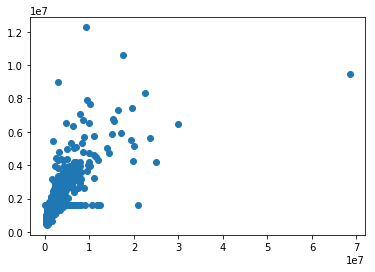

In [129]:
plt.scatter(y_test, y_test_lr.detach().numpy())

In [122]:
y_test.shape, X_test.shape

(torch.Size([1878, 1]), torch.Size([1878, 8]))

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
data = pd.read_excel('Sales_SE.xls')

In [47]:
1-sum(data['price']>0.5e7)/len(data)

0.9474356926026521

In [48]:
data[(data['latitude']>41)|(data['latitude']<40)|(data['longitude']<-74.2)|(data['longitude']>-73.5)]

,"(page, index)",latitude,longitude,address,Apt #,#beds,#baths,#square_feet,price


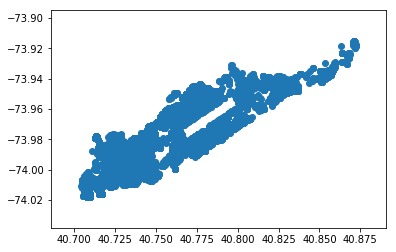

In [51]:
import matplotlib.pyplot as plt
plt.scatter(data['latitude'], data['longitude'])